# Homework 3

This assignment covers Harris corner detector, RANSAC and HOG descriptor.

In [2]:
# Setup
import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread
import matplotlib.pyplot as plt
from time import time

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction: Panorama Stitching
Panorama stitching is an early success of computer vision. Matthew Brown and David G. Lowe published a famous [panoramic image stitching paper](http://matthewalunbrown.com/papers/ijcv2007.pdf) in 2007. Since then, automatic panorama stitching technology has been widely adopted in many applications such as Google Street View, panorama photos on smartphones,
and stitching software such as Photosynth and AutoStitch.

In this assignment, we will detect and match keypoints from multiple images to build a single panoramic image. This will involve several tasks:
1. Use Harris corner detector to find keypoints.
2. Build a descriptor to describe each point in an image. <br>
   Compare two sets of descriptors coming from two different images and find matching keypoints.
3. Given a list of matching keypoints, use least-squares method to find the affine transformation matrix that maps points in one image to another.
4. Use RANSAC to give a more robust estimate of affine transformation matrix. <br>
   Given the transformation matrix, use it to transform the second image and overlay it on the first image, forming a panorama.
5. Implement a different descriptor (HOG descriptor) and get another stitching result.

## Part 1 Harris Corner Detector (20 points)


In this section, you are going to implement Harris corner detector for keypoint localization. Review the lecture slides on Harris corner detector to understand how it works. The Harris detection algorithm can be divide into the following steps:
1. Compute $x$ and $y$ derivatives ($I_x, I_y$) of an image
2. Compute products of derivatives ($I_x^2, I_y^2, I_{xy}$) at each pixel
3. Compute matrix $M$ at each pixel, where
$$
M = \sum_{x,y} w(x,y)
    \begin{bmatrix}
        I_{x}^2 & I_{x}I_{y} \\
        I_{x}I_{y} & I_{y}^2
    \end{bmatrix}
$$
4. Compute corner response $R=Det(M)-k(Trace(M)^2)$ at each pixel
5. Output corner response map $R(x,y)$

Step 1 is already done for you in the function **`harris_corners`** in `panorama.py`. Complete the function implementation and run the code below.

*-Hint: You may use the function `scipy.ndimage.filters.convolve`, which is already imported in `panoramy.py`*

参考链接：[Harris角点](https://www.cnblogs.com/ronny/p/4009425.html)
关于第三步，更好的理解方式是M矩阵的三种元素，用三个矩阵A,B,C表示，然后可以用窗口函数进行卷积，最后计算每个像素点的Harris响应。

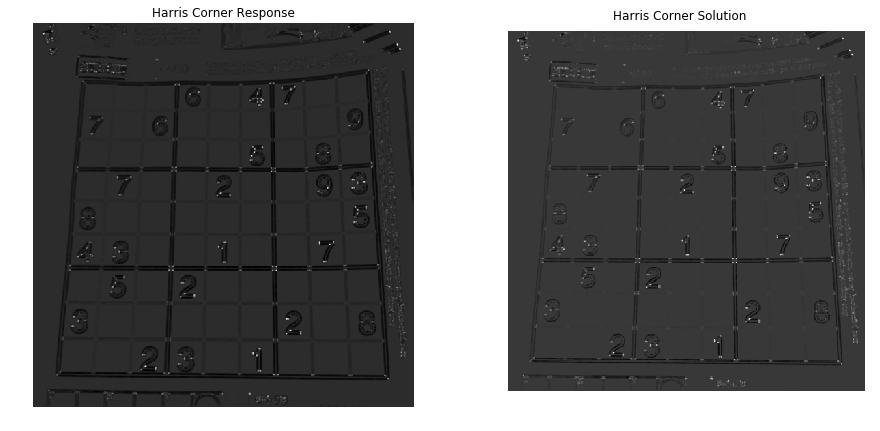

In [3]:
from panorama import harris_corners

img = imread('sudoku.png', as_grey=True)

# Compute Harris corner response
response = harris_corners(img)

# Display corner response
plt.subplot(1,2,1)
plt.imshow(response)
plt.axis('off')
plt.title('Harris Corner Response')

plt.subplot(1,2,2)
plt.imshow(imread('solution_harris.png', as_grey=True))
plt.axis('off')
plt.title('Harris Corner Solution')

plt.show()

Once you implement the Harris detector correctly, you will be able to see small bright blobs around the corners of the sudoku grids and letters in the output corner response image. The function `corner_peaks` from `skimage.feature` performs non-maximum suppression to take local maxima of the response map and localize keypoints.

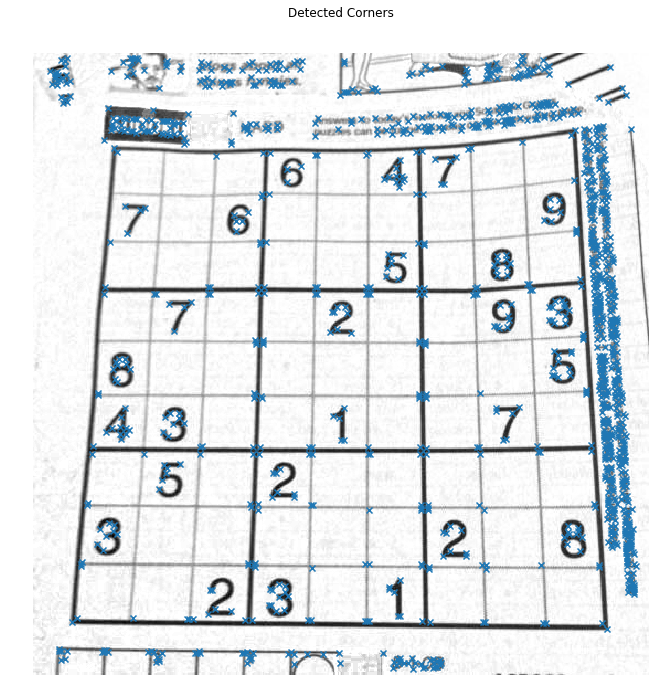

In [4]:
# Perform non-maximum suppression in response map
# and output corner coordiantes
corners = corner_peaks(response, threshold_rel=0.01)

# Display detected corners
plt.imshow(img)
plt.scatter(corners[:,1], corners[:,0], marker='x')
plt.axis('off')
plt.title('Detected Corners')
plt.show()

## Part 2 Describing and Matching Keypoints (20 points)

We are now able to localize keypoints in two images by running the Harris corner detector independently on them. Next question is, how do we determine which pair of keypoints come from corresponding locations in those two images? In order to *match* the detected keypoints, we must come up with a way to *describe* the keypoints based on their local appearance. Generally, each region around detected keypoint locations is converted into  a fixed-size vectors called *descriptors*.

### Part 2.1 Creating Descriptors (10 points)

In this section, you are going to implement a **`simple_descriptor`**; each keypoint is described by normalized intensity in a small patch around it.


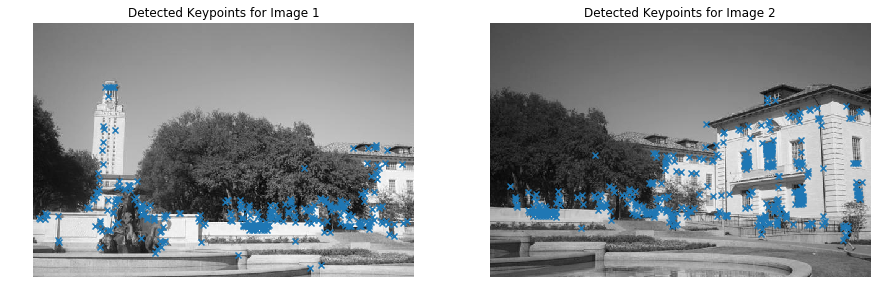

In [5]:
from panorama import harris_corners

img1 = imread('uttower1.jpg', as_grey=True)
img2 = imread('uttower2.jpg', as_grey=True)

# Detect keypoints in two images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

# Display detected keypoints
plt.subplot(1,2,1)
plt.imshow(img1)
plt.scatter(keypoints1[:,1], keypoints1[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(keypoints2[:,1], keypoints2[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()

### Part 2.2 Matching Descriptors (10 points)
Then, implement **`match_descriptors`** function to find good matches in two sets of descriptors. First, calculate Euclidean distance between all pairs of descriptors from image 1 and image 2. Then use this to determine if there is a good match: if the distance to the closest vector is significantly (by a factor which is given) smaller than the distance to the second-closest, we call it a match. The output of the function is an array where each row holds the indices of one pair of matching descriptors.

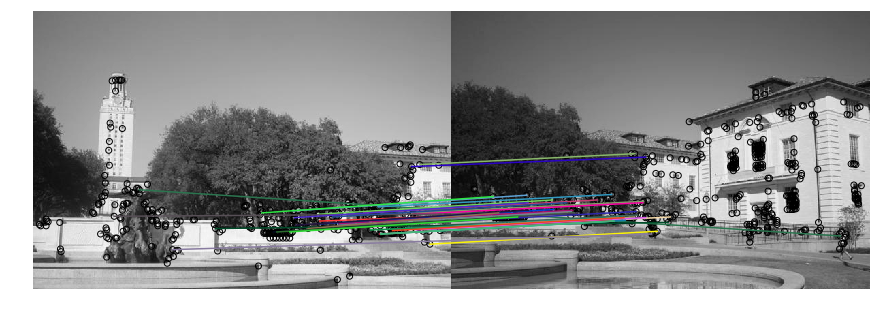

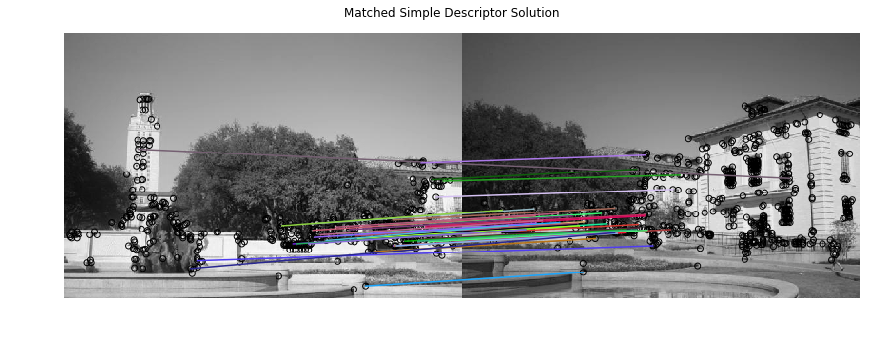

In [6]:
from panorama import simple_descriptor, match_descriptors, describe_keypoints
from utils import plot_matches

patch_size = 5

# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()
plt.imshow(imread('solution_simple_descriptor.png'))
plt.axis('off')
plt.title('Matched Simple Descriptor Solution')
plt.show()

## Part 3 Transformation Estimation (20 points)

We now have a list of matched keypoints across the two images. We will use this to find a transformation matrix that maps points in the second image to the corresponding coordinates in the first image. In other words, if the point $p_1 = [y_1,x_1]$ in image 1 matches with $p_2=[y_2, x_2]$ in image 2, we need to find an affine transformation matrix $H$ such that

$$
\tilde{p_2}H = \tilde{p_1},
$$

where $\tilde{p_1}$ and $\tilde{p_2}$ are homogenous coordinates of $p_1$ and $p_2$.

Note that it may be impossible to find the transformation $H$ that maps every point in image 2 exactly to the corresponding point in image 1. However, we can estimate the transformation matrix with least squares. Given $N$ matched keypoint pairs, let $X_1$ and $X_2$ be $N \times 3$ matrices whose rows are homogenous coordinates of corresponding keypoints in image 1 and image 2 respectively. Then, we can estimate $H$ by solving the least squares problem,

$$
X_2 H = X_1
$$

Implement **`fit_affine_matrix`** in `panorama.py`

*-Hint: read the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) about np.linalg.lstsq*

np.linalg.lstsq是个有用的好函数，用最小欧几里得二范数求得近似解。

记得了解lstsq的返回值的构造。lstsq返回四个元素。

In [49]:
from panorama import fit_affine_matrix
from utils import pad

# Sanity check for fit_affine_matrix

# Test inputs
a = np.array([[0.5, 0.1], [0.4, 0.2], [0.8, 0.2]])
b = np.array([[0.3, -0.2], [-0.4, -0.9], [0.1, 0.1]])

H = fit_affine_matrix(b, a)

# Target output
sol = np.array(
    [[1.25, 2.5, 0.0],
     [-5.75, -4.5, 0.0],
     [0.25, -1.0, 1.0]]
)

error = np.sum((H - sol) ** 2)

if error < 1e-20:
    print('Implementation correct!')
else:
    print('There is something wrong.')

Implementation correct!


After checking that your `fit_affine_matrix function` is running correctly, run the following code to apply it to images.
Images will be warped and image 2 will be mapped to image 1. Then, the two images are merged to get a panorama. Your panorama may not look good at this point, but we will later use other techniques to get a better result.

Output shape: [410 615]
Offset: [ 0.  0.]


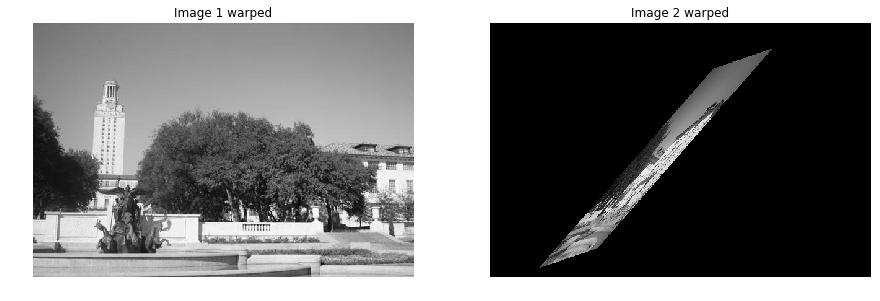

In [50]:
from utils import get_output_space, warp_image

# Extract matched keypoints
p1 = keypoints1[matches[:,0]]
p2 = keypoints2[matches[:,1]]
# Find affine transformation matrix H that maps p2 to p1
H = fit_affine_matrix(p1, p2)

output_shape, offset = get_output_space(img1, [img2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)


# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

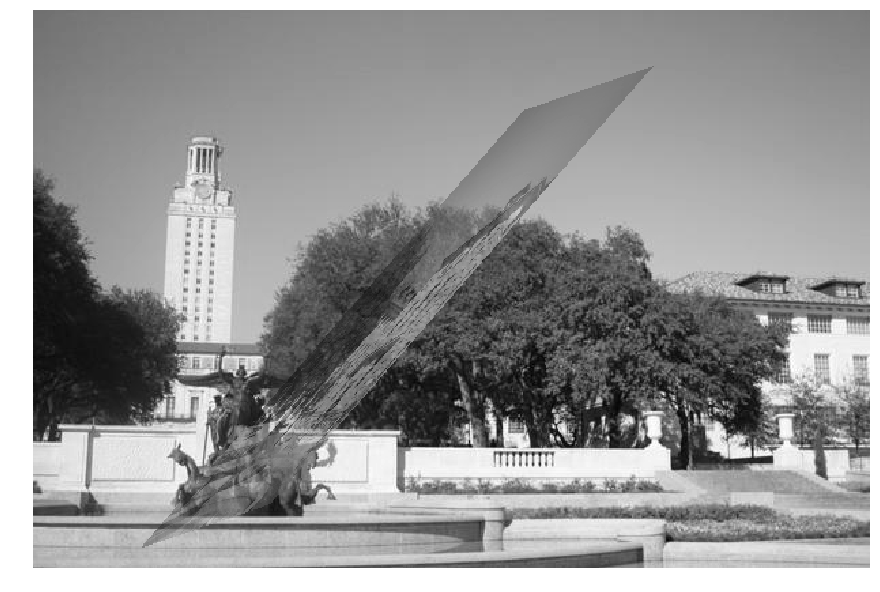

In [51]:
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.show()

## Part 4 RANSAC (20 points)
Rather than directly feeding all our keypoint matches into ``fit_affine_matrix`` function, we can instead use RANSAC ("RANdom SAmple Consensus") to select only "inliers" to use to compute the transformation matrix.

The steps of RANSAC are:
    1. Select random set of matches
    2. Compute affine transformation matrix
    3. Find inliers using the given threshold
    4. Repeat and keep the largest set of inliers
    5. Re-compute least-squares estimate on all of the inliers

Implement **`ransac`** in `panorama.py`, run through the following code to get a panorama. You can see the difference from the result we get without RANSAC.

**这题做不出，问题在于不知道threshold是什么评判标准**

15
(array([ 9, 16, 21, 22, 25, 26, 27, 28, 29, 33, 34, 35, 36, 37, 39], dtype=int64),)
[ 9 16 21 22 25 26 27 28 29 33 34 35 36 37 39]
(40, 2)
(15, 2)


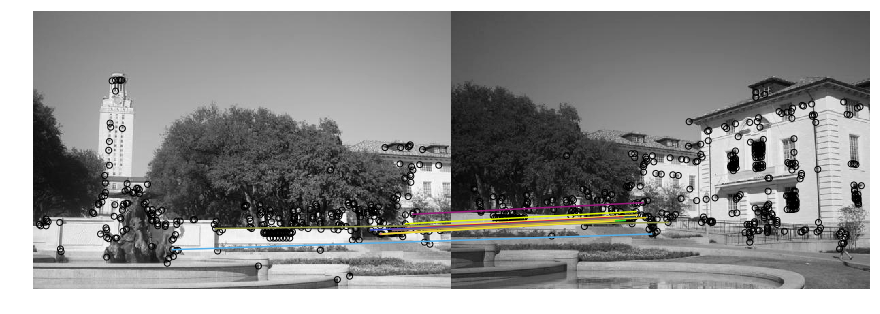

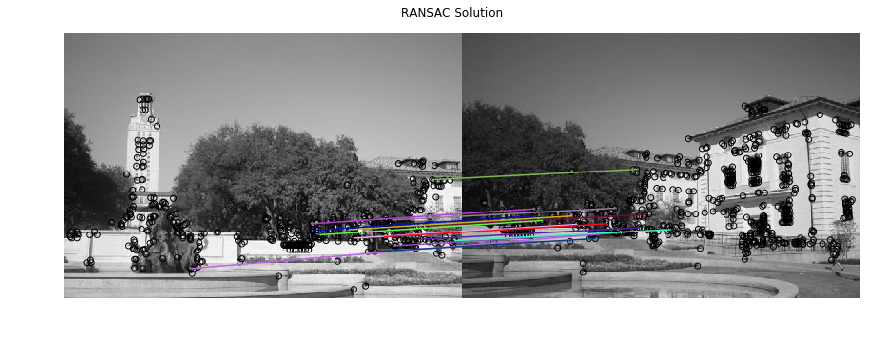

In [48]:
from panorama import ransac
H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=50)
print(robust_matches.shape)
# Visualize robust matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_ransac.png'))
plt.axis('off')
plt.title('RANSAC Solution')
plt.show()

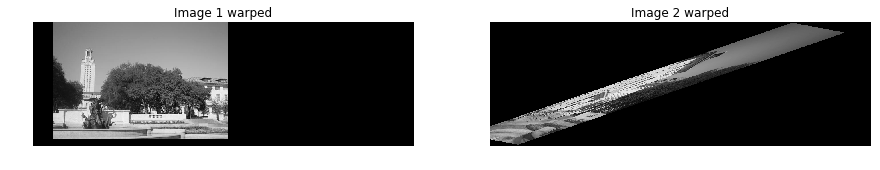

In [47]:
output_shape, offset = get_output_space(img1, [img2], [H])

# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

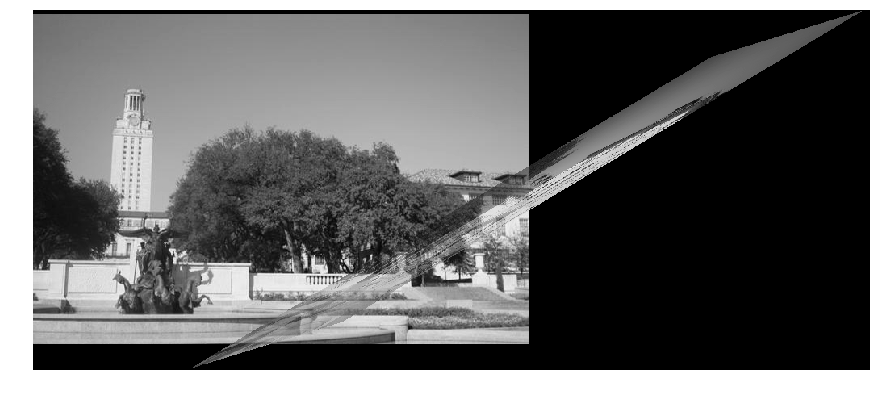

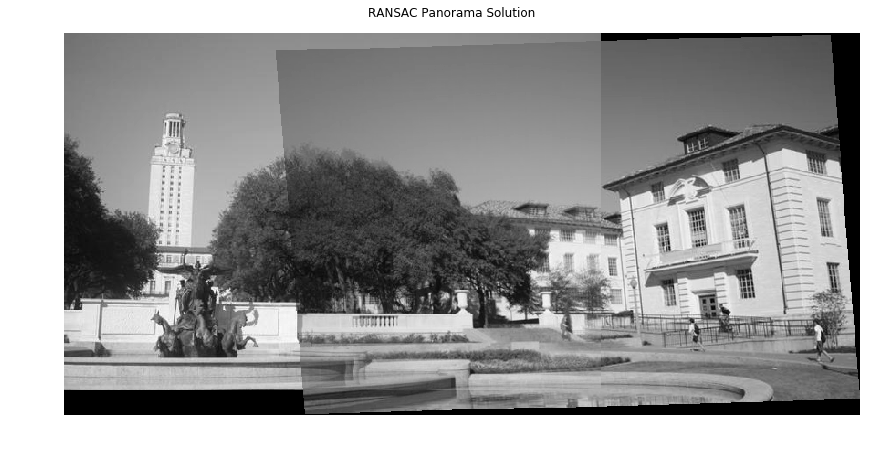

In [18]:
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_ransac_panorama.png'))
plt.axis('off')
plt.title('RANSAC Panorama Solution')
plt.show()

## Part 5 Histogram of Oriented Gradients (HOG) (20 points)
In the above code, you are using the `simple_descriptor`, and in this section, you are going to implement a simplified version of HOG descriptor. <br>
HOG stands for Histogram of	Oriented Gradients. In HOG descriptor, the distribution ( histograms ) of directions of gradients ( oriented gradients ) are used as features. Gradients ( x and y derivatives ) of an image are useful because the magnitude of gradients is large around edges and corners ( regions of abrupt intensity changes ) and we know that edges and corners pack in a lot more information about object shape than flat regions.<br>
The steps of HOG are: 
    1. compute the gradient image in x and y
        Use the sobel filter provided by skimage.filters
    2. compute gradient histograms
        Divide image into cells, and calculate histogram of gradient in each cell.
    3. normalize across block
        Normalize the histogram so that they 
    4. flattening block into a feature vector

Implement **`hog_descriptor`** in `panorama.py`, and run through the following code to get a panorama image.

In [168]:
from panorama import hog_descriptor

img1 = imread('uttower1.jpg', as_grey=True)
img2 = imread('uttower2.jpg', as_grey=True)

# Detect keypoints in both images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)


In [171]:
# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=hog_descriptor,
                           patch_size=16)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=hog_descriptor,
                           patch_size=16)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()
plt.imshow(imread('solution_hog.png'))
plt.axis('off')
plt.title('HOG descriptor Solution')
plt.show()

In [177]:
from panorama import ransac
H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=1)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_hog_ransac.png'))
plt.axis('off')
plt.title('HOG descriptor Solution')
plt.show()

In [15]:
output_shape, offset = get_output_space(img1, [img2], [H])

# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

In [178]:
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_hog_panorama.png'))
plt.axis('off')
plt.title('HOG Descriptor Panorama Solution')
plt.show()

## Extra Credit: Better Image Merging
You will notice the blurry region and unpleasant lines in the middle of the final panoramic image. In the cell below, come up with a better merging scheme to make the panorama look more natural. Be creative!

In [17]:
# Modify the code below

### YOUR CODE HERE
merged = img1_warped + img2_warped

overlap = (img1_mask * 1.0 + img2_mask)

output = merged / np.maximum(overlap, 1)
### END YOUR CODE

plt.imshow(output)
plt.axis('off')
plt.show()

## Extra Credit: Stitching Multiple Images
Work in the cell below to complete the code to stitch an ordered chain of images.

Given a sequence of $m$ images ($I_1, I_2,...,I_m$), take every neighboring pair of images and compute the transformation matrix which converts points from the coordinate frame of $I_{i+1}$ to the frame of $I_{i}$. Then, select a reference image $I_{ref}$, which is in the middle of the chain. We want our final panorama image to be in the coordinate frame of $I_{ref}$. So, for each $I_i$ that is not the reference image, we need a transformation matrix that will convert points in frame $i$ to frame $ref$.

*-Hint:*
- If you are confused, you may want to review the Linear Algebra slides on how to combine the effects of multiple transformation matrices.
- The inverse of transformation matrix has the reverse effect. Please use [`numpy.linalg.inv`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html) function whenever you want to compute matrix inverse.

In [18]:
img1 = imread('yosemite1.jpg', as_grey=True)
img2 = imread('yosemite2.jpg', as_grey=True)
img3 = imread('yosemite3.jpg', as_grey=True)
img4 = imread('yosemite4.jpg', as_grey=True)

# Detect keypoints in each image
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints3 = corner_peaks(harris_corners(img3, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints4 = corner_peaks(harris_corners(img4, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

# Describe keypoints
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc3 = describe_keypoints(img3, keypoints3,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc4 = describe_keypoints(img4, keypoints4,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

# Match keypoints in neighboring images
matches12 = match_descriptors(desc1, desc2, 0.7)
matches23 = match_descriptors(desc2, desc3, 0.7)
matches34 = match_descriptors(desc3, desc4, 0.7)

### YOUR CODE HERE
### END YOUR CODE

In [53]:
# Visualize final panorama image
plt.imshow(panorama)
plt.axis('off')
plt.show()